# Import packages & functions

In [1]:
import os
import sys
import json
import argparse
import numpy as np
import time
import random
import string
import h5py
from tqdm import tqdm
import webdataset as wds
from PIL import Image
import pandas as pd
import nibabel as nib

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms

# tf32 data type is faster than standard float32
torch.backends.cuda.matmul.allow_tf32 = True

# custom functions #
seed = 0
import utils

from IPython.display import clear_output # function to clear print outputs in cell
%load_ext autoreload 
# this allows you to change functions in models.py or utils.py and have this notebook automatically update with your revisions
%autoreload 2 

# Data

### betas

In [2]:
# vox = np.load("glmsingle/TYPEB_FITHRF.npz")['betasmd'][:,0,0].T
# vox.shape # num_trials, num_features

In [5]:
features = pd.read_parquet('/weka/proj-fmri/paulscotti/fMRI-foundation-model/flat/checkpoints/nsdflat_large/epoch99/test.parquet')
features

,feature,key,sub,ses,run,start,events
0,"[1.2957616, 0.8341554, 0.977095, 0.7594984, 0....",sub-01_ses-25_run-09,1,25,9,0,"[{'index': 12, 'nsd_id': 45455}, {'index': 16,..."
1,"[1.6828736, 0.76685095, 0.801588, 1.1775866, 0...",sub-01_ses-25_run-09,1,25,9,16,"[{'index': 12, 'nsd_id': 45455}, {'index': 16,..."
2,"[1.3467954, 0.62295175, 0.53726166, 0.94804835...",sub-01_ses-25_run-09,1,25,9,32,"[{'index': 12, 'nsd_id': 45455}, {'index': 16,..."
3,"[1.2597265, 0.56107175, 0.88799864, 1.0987167,...",sub-01_ses-25_run-09,1,25,9,48,"[{'index': 12, 'nsd_id': 45455}, {'index': 16,..."
4,"[0.9291683, 0.7384197, 0.43327004, 0.96608216,...",sub-01_ses-25_run-09,1,25,9,64,"[{'index': 12, 'nsd_id': 45455}, {'index': 16,..."
...,...,...,...,...,...,...,...
146683,"[0.39492762, 0.9567513, 1.9104024, 0.6862465, ...",sub-01_ses-09_run-07,1,9,7,15,"[{'index': 12, 'nsd_id': 46391}, {'index': 16,..."
146684,"[0.6176336, 0.97453976, 1.6229396, 0.7125873, ...",sub-01_ses-09_run-07,1,9,7,31,"[{'index': 12, 'nsd_id': 46391}, {'index': 16,..."
146685,"[0.36875397, 0.9014565, 2.026524, 0.7028155, 0...",sub-01_ses-09_run-07,1,9,7,47,"[{'index': 12, 'nsd_id': 46391}, {'index': 16,..."
146686,"[0.11672564, 0.7731965, 2.1594627, 0.8890982, ...",sub-01_ses-09_run-07,1,9,7,63,"[{'index': 12, 'nsd_id': 46391}, {'index': 16,..."


In [6]:
n_sessions = 40 # ses ranges from 1 to 40
sess = 1
n_runs = features[(features['ses']==sess)]['run'].max()
n_TRs = len(features[(features['ses']==sess)&(features['run']==1)])
n_features = len(features[(features['ses']==sess)]['feature'].values[0])
print(f"n_sessions {n_sessions}  sess {sess}  n_runs {n_runs}  n_TRs {n_TRs}  n_features {n_features}")

n_sessions 40  sess 1  n_runs 12  n_TRs 285  n_features 1024


In [85]:
# DESIGN MATRIX
images = []
indices = []
run_ids = []
for r in range(1,n_runs+1):
    images = np.append(images, [even['nsd_id'] for even in features[(features['run']==r)&(features['ses']==sess)&(features['start']==0)]['events'].values[0]])
    indices = np.append(indices, [even['index'] for even in features[(features['run']==r)&(features['ses']==sess)&(features['start']==0)]['events'].values[0]])
    run_ids = np.append(run_ids, np.repeat(r, len([even['index'] for even in features[(features['run']==r)&(features['ses']==sess)&(features['start']==0)]['events'].values[0]])))

len_images = len(images)
print(len_images)
unique_images = np.unique(images)
len_unique_images = len(unique_images)
print(len_unique_images)

750
583


In [86]:
data = [np.zeros((n_features, n_TRs)) for _ in range(n_runs)]
for cur_run in range(1,n_runs+1):
    print(f"run = {cur_run}")
    for timepoint in range(n_TRs):
        feats = features[(features['run']==cur_run)&(features['ses']==sess)&(features['start']==0)]['feature'].values[0]
        data[cur_run-1][:, timepoint] = feats
    # data[cur_run-1] = utils.zscore(data[cur_run-1])
print(data[1].shape)

run = 1
run = 2
run = 3
run = 4
run = 5
run = 6
run = 7
run = 8
run = 9
run = 10
run = 11
run = 12
(1024, 285)


In [88]:
vox = None
delay = 4
for ii,(im,idx,run) in enumerate(zip(images,indices,run_ids)):
    run = int(run - 1)
    idx = int(idx + delay)
    cur_features = data[run][:,idx]
    if vox is None:
        vox = cur_features[None]
    else:
        vox = np.vstack((vox, cur_features[None]))
        
print(vox.shape)

(750, 1024)


### Images

In [89]:
# Load 73k NSD images
data_path = "/weka/proj-medarc/shared/mindeyev2_dataset"
f = h5py.File(f'{data_path}/coco_images_224_float16.hdf5', 'r')
images = f['images'][:]
images = torch.Tensor(images).to("cpu")

In [90]:
images_idx = np.load("sess1_images.npy").astype(np.int64)
images = images[images_idx]
print(images.shape)

torch.Size([750, 3, 224, 224])


In [91]:
print(vox.shape)
print(images.shape)

(750, 1024)
torch.Size([750, 3, 224, 224])


In [92]:
utils.seed_everything(0)

all_indices = np.random.permutation(np.arange(len(images)))
print(len(all_indices))
train_image_indices = all_indices[:int(len(images)*.75)]
test_image_indices = all_indices[int(len(images)*.75):]
print(len(train_image_indices), len(test_image_indices))

750
562 188


In [93]:
train_mean = np.mean(vox[train_image_indices],axis=0)
train_std = np.std(vox[train_image_indices],axis=0)

vox = utils.zscore(vox,train_mean=train_mean,train_std=train_std)
print("voxels have been zscored")
print(vox[:,0].mean(), vox[:,0].std())
print("vox", vox.shape)

images = torch.Tensor(images)
vox = torch.Tensor(vox)

voxels have been zscored
-0.0011424535909438304 1.0088983015449284
vox (750, 1024)


In [94]:
### Multi-GPU config ###
from accelerate import Accelerator, DeepSpeedPlugin

local_rank = os.getenv('RANK')
if local_rank is None: 
    local_rank = 0
else:
    local_rank = int(local_rank)
print("LOCAL RANK ", local_rank)  

data_type = torch.float32 # change depending on your mixed_precision

accelerator = Accelerator(split_batches=False)# mixed_precision="fp16") # ['no', 'fp8', 'fp16', 'bf16']
batch_size = 8 # 8 # 24

LOCAL RANK  0


In [95]:
print("PID of this process =",os.getpid())
device = accelerator.device
print("device:",device)
world_size = accelerator.state.num_processes
distributed = not accelerator.state.distributed_type == 'NO'
num_devices = torch.cuda.device_count()
global_batch_size = batch_size * num_devices
print("global_batch_size", global_batch_size)
if num_devices==0 or not distributed: num_devices = 1
num_workers = num_devices
print(accelerator.state)

# set data_type to match your mixed precision (automatically set based on deepspeed config)
if accelerator.mixed_precision == "bf16":
    data_type = torch.bfloat16
elif accelerator.mixed_precision == "fp16":
    data_type = torch.float16
else:
    data_type = torch.float32

print("distributed =",distributed, "num_devices =", num_devices, "local rank =", local_rank, "world size =", world_size, "data_type =", data_type)
print = accelerator.print # only print if local_rank=0

PID of this process = 1280195
device: cuda
global_batch_size 8
Distributed environment: DistributedType.NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: no

distributed = False num_devices = 1 local rank = 0 world size = 1 data_type = torch.float32


## Configurations

In [96]:
# if running this interactively, can specify jupyter_args here for argparser to use
if utils.is_interactive():
    model_name = "testing__"
    print("model_name:", model_name)
    
    # global_batch_size and batch_size should already be defined in the above cells
    # other variables can be specified in the following string:
    jupyter_args = f"--data_path=/weka/proj-medarc/shared/mindeyev2_dataset \
                    --model_name={model_name} \
                    --no-multi_subject --subj=1 --batch_size={batch_size} \
                    --hidden_dim=1024 --clip_scale=1. \
                    --no-blurry_recon --blur_scale=.5 \
                    --no-use_prior --prior_scale=30 --no-visualize_prior \
                    --n_blocks=4 --max_lr=3e-4 --mixup_pct=.33 --num_epochs=20 --no-use_image_aug \
                    --ckpt_interval=999 --no-ckpt_saving --no-wandb_log --new_test"# \
                    #--multisubject_ckpt=../../train_logs/multisubject_subj01_1024hid_nolow_300ep_seed0"
    # --multisubject_ckpt=../../train_logs/multisubject_subj01_1024hid_nolow_300ep_seed0"
    # /weka/proj-fmri/paulscotti/MindEye2_git/train_logs/final_subj01_pretrained_40sess_24bs
    # subj01_pretrained_1sess_1024hid_nolow_seed7
    print(jupyter_args)
    jupyter_args = jupyter_args.split()
    
    from IPython.display import clear_output # function to clear print outputs in cell
    %load_ext autoreload 
    # this allows you to change functions in models.py or utils.py and have this notebook automatically update with your revisions
    %autoreload 2 

model_name: testing__
--data_path=/weka/proj-medarc/shared/mindeyev2_dataset                     --model_name=testing__                     --no-multi_subject --subj=1 --batch_size=8                     --hidden_dim=1024 --clip_scale=1.                     --no-blurry_recon --blur_scale=.5                     --no-use_prior --prior_scale=30 --no-visualize_prior                     --n_blocks=4 --max_lr=3e-4 --mixup_pct=.33 --num_epochs=20 --no-use_image_aug                     --ckpt_interval=999 --no-ckpt_saving --no-wandb_log --new_test
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [97]:
parser = argparse.ArgumentParser(description="Model Training Configuration")
parser.add_argument(
    "--model_name", type=str, default="testing",
    help="name of model, used for ckpt saving and wandb logging (if enabled)",
)
parser.add_argument(
    "--data_path", type=str, default="/weka/proj-fmri/shared/natural-scenes-dataset",
    help="Path to where NSD data is stored / where to download it to",
)
parser.add_argument(
    "--subj",type=int, default=1, choices=[1,2,3,4,5,6,7,8],
    help="Validate on which subject?",
)
parser.add_argument(
    "--multisubject_ckpt", type=str, default=None,
    help="Path to pre-trained multisubject model to finetune a single subject from. multisubject must be False.",
)
parser.add_argument(
    "--num_sessions", type=int, default=0,
    help="Number of training sessions to include (if multi_subject, this variable doesnt matter)",
)
parser.add_argument(
    "--use_prior",action=argparse.BooleanOptionalAction,default=False,
    help="whether to train diffusion prior (True) or just rely on retrieval part of the pipeline (False)",
)
parser.add_argument(
    "--visualize_prior",action=argparse.BooleanOptionalAction,default=False,
    help="output visualizations from unCLIP every ckpt_interval (requires more memory!)",
)
parser.add_argument(
    "--batch_size", type=int, default=32,
    help="Batch size can be increased by 10x if only training v2c and not diffusion diffuser",
)
parser.add_argument(
    "--wandb_log",action=argparse.BooleanOptionalAction,default=False,
    help="whether to log to wandb",
)
parser.add_argument(
    "--resume_from_ckpt",action=argparse.BooleanOptionalAction,default=False,
    help="if not using wandb and want to resume from a ckpt",
)
parser.add_argument(
    "--wandb_project",type=str,default="stability",
    help="wandb project name",
)
parser.add_argument(
    "--mixup_pct",type=float,default=.33,
    help="proportion of way through training when to switch from BiMixCo to SoftCLIP",
)
parser.add_argument(
    "--low_mem",action=argparse.BooleanOptionalAction,default=False,
    help="whether to preload images to cpu to speed things up but consume more memory",
)
parser.add_argument(
    "--blurry_recon",action=argparse.BooleanOptionalAction,default=True,
    help="whether to output blurry reconstructions",
)
parser.add_argument(
    "--blur_scale",type=float,default=.5,
    help="multiply loss from blurry recons by this number",
)
parser.add_argument(
    "--clip_scale",type=float,default=1.,
    help="multiply contrastive loss by this number",
)
parser.add_argument(
    "--prior_scale",type=float,default=30,
    help="multiply diffusion prior loss by this",
)
parser.add_argument(
    "--use_image_aug",action=argparse.BooleanOptionalAction,default=True,
    help="whether to use image augmentation",
)
parser.add_argument(
    "--num_epochs",type=int,default=120,
    help="number of epochs of training",
)
parser.add_argument(
    "--multi_subject",action=argparse.BooleanOptionalAction,default=False,
)
parser.add_argument(
    "--new_test",action=argparse.BooleanOptionalAction,default=True,
)
parser.add_argument(
    "--n_blocks",type=int,default=2,
)
parser.add_argument(
    "--hidden_dim",type=int,default=1024,
)
parser.add_argument(
    "--seq_past",type=int,default=0,
)
parser.add_argument(
    "--seq_future",type=int,default=0,
)
parser.add_argument(
    "--lr_scheduler_type",type=str,default='cycle',choices=['cycle','linear'],
)
parser.add_argument(
    "--ckpt_saving",action=argparse.BooleanOptionalAction,default=True,
)
parser.add_argument(
    "--ckpt_interval",type=int,default=5,
    help="save backup ckpt and reconstruct every x epochs",
)
parser.add_argument(
    "--seed",type=int,default=42,
)
parser.add_argument(
    "--max_lr",type=float,default=3e-4,
)

if utils.is_interactive():
    args = parser.parse_args(jupyter_args)
else:
    args = parser.parse_args()

# create global variables without the args prefix
for attribute_name in vars(args).keys():
    globals()[attribute_name] = getattr(args, attribute_name)
    
# seed all random functions
utils.seed_everything(seed)

outdir = os.path.abspath(f'../../train_logs/{model_name}')
if not os.path.exists(outdir) and ckpt_saving:
    os.makedirs(outdir,exist_ok=True)
    
if use_image_aug or blurry_recon:
    import kornia
    import kornia.augmentation as K
    from kornia.augmentation.container import AugmentationSequential
if use_image_aug:
    img_augment = AugmentationSequential(
        kornia.augmentation.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1, p=0.3),
        same_on_batch=False,
        data_keys=["input"],
    )
    # Define the blurring augmentations
    blur_augment = K.RandomGaussianBlur(kernel_size=(21, 21), sigma=(51.0, 51.0), p=1.)
    
if multi_subject:
    subj_list = np.arange(1,9)
    subj_list = subj_list[subj_list != subj]
else:
    subj_list = [subj]

print("subj_list", subj_list, "num_sessions", num_sessions)

subj_list [1] num_sessions 0


## Prep data, models, and dataloaders

### Creating wds dataloader, preload betas and all 73k possible images

In [98]:
def my_split_by_node(urls): return urls
num_voxels_list = []

if multi_subject:
    nsessions_allsubj=np.array([40, 40, 32, 30, 40, 32, 40, 30])
    num_samples_per_epoch = (750*40) // num_devices 
else:
    # num_samples_per_epoch = (750*num_sessions) // num_devices 
    num_samples_per_epoch = len(train_image_indices)

print("dividing batch size by subj_list, which will then be concatenated across subj during training...") 
batch_size = batch_size // len(subj_list)

num_iterations_per_epoch = num_samples_per_epoch // (batch_size*len(subj_list))

print("batch_size =", batch_size, "num_iterations_per_epoch =",num_iterations_per_epoch, "num_samples_per_epoch =",num_samples_per_epoch)

dividing batch size by subj_list, which will then be concatenated across subj during training...
batch_size = 8 num_iterations_per_epoch = 70 num_samples_per_epoch = 562


In [99]:
train_data = {}
train_dl = {}

train_data[f'subj0{subj}'] = torch.utils.data.TensorDataset(torch.tensor(train_image_indices))

test_data = torch.utils.data.TensorDataset(torch.tensor(test_image_indices))

In [100]:
num_voxels = {}
voxels = {}
for s in subj_list:
    print(f"Training with {num_sessions} sessions")
    train_dl = torch.utils.data.DataLoader(train_data[f'subj0{s}'], batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)

    num_voxels_list.append(vox[0].shape[-1])
    num_voxels[f'subj0{s}'] = vox[0].shape[-1]
    voxels[f'subj0{s}'] = vox
    print(f"num_voxels for subj0{s}: {num_voxels[f'subj0{s}']}")

print("Loaded all subj train dls and vox!\n")

# Validate only on one subject
if multi_subject: 
    subj = subj_list[0] # cant validate on the actual held out person so picking first in subj_list
test_dl = torch.utils.data.DataLoader(test_data, batch_size=24, shuffle=False, drop_last=True, pin_memory=True)

print(f"Loaded test dl for subj{subj}!\n")

Training with 0 sessions
num_voxels for subj01: 1024
Loaded all subj train dls and vox!

Loaded test dl for subj1!



## Load models

### CLIP image embeddings  model

In [101]:
## USING OpenCLIP ViT-bigG ###
sys.path.append('generative_models/')
import sgm
from generative_models.sgm.modules.encoders.modules import FrozenOpenCLIPImageEmbedder
# from generative_models.sgm.models.diffusion import DiffusionEngine
# from omegaconf import OmegaConf

try:
    print(clip_img_embedder)
except:
    clip_img_embedder = FrozenOpenCLIPImageEmbedder(
        arch="ViT-bigG-14",
        version="laion2b_s39b_b160k",
        output_tokens=True,
        only_tokens=True,
    )
    clip_img_embedder.to(device)
clip_seq_dim = 256
clip_emb_dim = 1664

# ## USING OPEN AI CLIP ViT-L ###
# import clip
# try:
#     print(clip_model)
# except:
#     clip_model, preprocess = clip.load("ViT-L/14", device=device)
#     preprocess = transforms.Compose([
#         transforms.Resize(224, interpolation=transforms.InterpolationMode.BILINEAR),
#         transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
#                              std=[0.26862954, 0.26130258, 0.27577711]),
#     ])
# def clip_img_embedder(image):
#     preproc_img = preprocess(image)
#     return clip_model.encode_image(preproc_img)
# clip_seq_dim = 1
# clip_emb_dim = 768

FrozenOpenCLIPImageEmbedder(
  (model): CLIP(
    (visual): VisionTransformer(
      (conv1): Conv2d(3, 1664, kernel_size=(14, 14), stride=(14, 14), bias=False)
      (patch_dropout): Identity()
      (ln_pre): LayerNorm((1664,), eps=1e-05, elementwise_affine=True)
      (transformer): Transformer(
        (resblocks): ModuleList(
          (0-47): 48 x ResidualAttentionBlock(
            (ln_1): LayerNorm((1664,), eps=1e-05, elementwise_affine=True)
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=1664, out_features=1664, bias=True)
            )
            (ls_1): Identity()
            (ln_2): LayerNorm((1664,), eps=1e-05, elementwise_affine=True)
            (mlp): Sequential(
              (c_fc): Linear(in_features=1664, out_features=8192, bias=True)
              (gelu): GELU(approximate='none')
              (c_proj): Linear(in_features=8192, out_features=1664, bias=True)
            )
            (ls_2): Identity()


### MindEye modules

In [102]:
class MindEyeModule(nn.Module):
    def __init__(self):
        super(MindEyeModule, self).__init__()
    def forward(self, x):
        return x
        
model = MindEyeModule()
model

MindEyeModule()

In [103]:
class RidgeRegression(torch.nn.Module):
    # make sure to add weight_decay when initializing optimizer
    def __init__(self, input_sizes, out_features, seq_len=1): 
        super(RidgeRegression, self).__init__()
        self.seq_len = seq_len
        self.out_features = out_features
        self.linears = torch.nn.ModuleList([
                torch.nn.Linear(input_size, out_features) for input_size in input_sizes
            ])
    def forward(self, x, subj_idx=0):
        out = torch.cat([self.linears[subj_idx](x[:,seq]).unsqueeze(1) for seq in range(self.seq_len)], dim=1)
        return out
        
model.ridge = RidgeRegression(num_voxels_list, out_features=hidden_dim)
utils.count_params(model.ridge)
utils.count_params(model)

# test on subject 1 with fake data
b = torch.randn((2,1,num_voxels_list[0]))
print(b.shape, model.ridge(b,0).shape)

param counts:
1,049,600 total
1,049,600 trainable
param counts:
1,049,600 total
1,049,600 trainable
torch.Size([2, 1, 1024]) torch.Size([2, 1, 1024])


In [104]:
from functools import partial
# from diffusers.models.vae import Decoder
class BrainNetwork(nn.Module):
    def __init__(self, h=4096, in_dim=15724, out_dim=768, seq_len=1, n_blocks=n_blocks, drop=.15, 
                 clip_size=768):
        super().__init__()
        self.seq_len = seq_len
        self.h = h
        self.clip_size = clip_size
        
        self.mixer_blocks1 = nn.ModuleList([
            self.mixer_block1(h, drop) for _ in range(n_blocks)
        ])
        self.mixer_blocks2 = nn.ModuleList([
            self.mixer_block2(seq_len, drop) for _ in range(n_blocks)
        ])
        
        # Output linear layer
        self.backbone_linear = nn.Linear(h * seq_len, out_dim, bias=True) 
        if clip_scale>0:
            self.clip_proj = self.projector(clip_size, clip_size, h=clip_size)
            
    def projector(self, in_dim, out_dim, h=2048):
        return nn.Sequential(
            nn.LayerNorm(in_dim),
            nn.GELU(),
            nn.Linear(in_dim, h),
            nn.LayerNorm(h),
            nn.GELU(),
            nn.Linear(h, h),
            nn.LayerNorm(h),
            nn.GELU(),
            nn.Linear(h, out_dim)
        )
    
    def mlp(self, in_dim, out_dim, drop):
        return nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.GELU(),
            nn.Dropout(drop),
            nn.Linear(out_dim, out_dim),
        )
    
    def mixer_block1(self, h, drop):
        return nn.Sequential(
            nn.LayerNorm(h),
            self.mlp(h, h, drop),  # Token mixing
        )

    def mixer_block2(self, seq_len, drop):
        return nn.Sequential(
            nn.LayerNorm(seq_len),
            self.mlp(seq_len, seq_len, drop)  # Channel mixing
        )
        
    def forward(self, x):
        # make empty tensors
        c,b = torch.Tensor([0.]), torch.Tensor([[0.],[0.]])
        
        # Mixer blocks
        residual1 = x
        residual2 = x.permute(0,2,1)
        for block1, block2 in zip(self.mixer_blocks1,self.mixer_blocks2):
            x = block1(x) + residual1
            residual1 = x
            x = x.permute(0,2,1)
            
            x = block2(x) + residual2
            residual2 = x
            x = x.permute(0,2,1)
            
        x = x.reshape(x.size(0), -1)
        backbone = self.backbone_linear(x).reshape(len(x), -1, self.clip_size)
        if clip_scale>0:
            c = self.clip_proj(backbone)
        
        return backbone, c, b

model.backbone = BrainNetwork(h=hidden_dim, in_dim=hidden_dim, seq_len=1, 
                          clip_size=clip_emb_dim, out_dim=clip_emb_dim*clip_seq_dim)
utils.count_params(model.backbone)
utils.count_params(model)

# test that the model works on some fake data
b = torch.randn((2,1,hidden_dim))
print("b.shape",b.shape)

backbone_, clip_, blur_ = model.backbone(b)
print(backbone_.shape, clip_.shape, blur_[0].shape, blur_[1].shape)

param counts:
453,360,280 total
453,360,280 trainable
param counts:
454,409,880 total
454,409,880 trainable
b.shape torch.Size([2, 1, 1024])
torch.Size([2, 256, 1664]) torch.Size([2, 256, 1664]) torch.Size([1]) torch.Size([1])


### Adding diffusion prior + unCLIP if use_prior=True

In [105]:
if use_prior:
    from models import *

    # setup diffusion prior network
    out_dim = clip_emb_dim
    depth = 6
    dim_head = 52
    heads = clip_emb_dim//52 # heads * dim_head = clip_emb_dim
    timesteps = 100

    prior_network = VersatileDiffusionPriorNetwork(
            dim=out_dim,
            depth=depth,
            dim_head=dim_head,
            heads=heads,
            causal=False,
            num_tokens = clip_seq_dim,
            learned_query_mode="pos_emb"
        )

    model.diffusion_prior = BrainDiffusionPrior(
        net=prior_network,
        image_embed_dim=out_dim,
        condition_on_text_encodings=False,
        timesteps=timesteps,
        cond_drop_prob=0.2,
        image_embed_scale=None,
    )
    
    utils.count_params(model.diffusion_prior)
    utils.count_params(model)
    
    # prep unCLIP
    if visualize_prior:
        config = OmegaConf.load("generative_models/configs/unclip6.yaml")
        config = OmegaConf.to_container(config, resolve=True)
        unclip_params = config["model"]["params"]
        network_config = unclip_params["network_config"]
        denoiser_config = unclip_params["denoiser_config"]
        first_stage_config = unclip_params["first_stage_config"]
        conditioner_config = unclip_params["conditioner_config"]
        sampler_config = unclip_params["sampler_config"]
        scale_factor = unclip_params["scale_factor"]
        disable_first_stage_autocast = unclip_params["disable_first_stage_autocast"]
        offset_noise_level = unclip_params["loss_fn_config"]["params"]["offset_noise_level"]

        first_stage_config['target'] = 'sgm.models.autoencoder.AutoencoderKL'
        sampler_config['params']['num_steps'] = 38

        diffusion_engine = DiffusionEngine(network_config=network_config,
                               denoiser_config=denoiser_config,
                               first_stage_config=first_stage_config,
                               conditioner_config=conditioner_config,
                               sampler_config=sampler_config,
                               scale_factor=scale_factor,
                               disable_first_stage_autocast=disable_first_stage_autocast)
        # set to inference
        diffusion_engine.eval().requires_grad_(False)
        diffusion_engine.to(device)

        ckpt_path = '/weka/proj-fmri/shared/mindeyev2_dataset/unclip6_epoch0_step110000.ckpt'
        ckpt = torch.load(ckpt_path, map_location='cpu')
        diffusion_engine.load_state_dict(ckpt['state_dict'])

        image = images[:1].to(device)
        batch={"jpg": image,
              "original_size_as_tuple": torch.ones(image.shape[0], 2).to(device) * 768,
              "crop_coords_top_left": torch.zeros(image.shape[0], 2).to(device)}
        out = diffusion_engine.conditioner(batch)
        vector_suffix = out["vector"].to(device)
        print("vector_suffix", vector_suffix.shape)

### Setup optimizer / lr / ckpt saving

In [106]:
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']

opt_grouped_parameters = [
    {'params': [p for n, p in model.ridge.named_parameters()], 'weight_decay': 1e-2},
    {'params': [p for n, p in model.backbone.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 1e-2},
    {'params': [p for n, p in model.backbone.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
]
# model.backbone.requires_grad_(False)

if use_prior:
    opt_grouped_parameters.extend([
        {'params': [p for n, p in model.diffusion_prior.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 1e-2},
        {'params': [p for n, p in model.diffusion_prior.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ])

optimizer = torch.optim.AdamW(opt_grouped_parameters, lr=max_lr)

if lr_scheduler_type == 'linear':
    lr_scheduler = torch.optim.lr_scheduler.LinearLR(
        optimizer,
        total_iters=int(np.floor(num_epochs*num_iterations_per_epoch)),
        last_epoch=-1
    )
elif lr_scheduler_type == 'cycle':
    if num_iterations_per_epoch==0:
        num_iterations_per_epoch=1
    total_steps=int(np.floor(num_epochs*num_iterations_per_epoch))
    print("total_steps", total_steps)
    lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, 
        max_lr=max_lr,
        total_steps=total_steps,
        final_div_factor=1000,
        last_epoch=-1, pct_start=2/num_epochs
    )
    
def save_ckpt(tag):
    ckpt_path = outdir+f'/{tag}.pth'
    if accelerator.is_main_process:
        unwrapped_model = accelerator.unwrap_model(model)
        torch.save({
            'epoch': epoch,
            'model_state_dict': unwrapped_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr_scheduler': lr_scheduler.state_dict(),
            'train_losses': losses,
            'test_losses': test_losses,
            'lrs': lrs,
            }, ckpt_path)
    print(f"\n---saved {outdir}/{tag} ckpt!---\n")

def load_ckpt(tag,load_lr=True,load_optimizer=True,load_epoch=True,strict=True,outdir=outdir,multisubj_loading=False): 
    print(f"\n---loading {outdir}/{tag}.pth ckpt---\n")
    checkpoint = torch.load(outdir+'/last.pth', map_location='cpu')
    state_dict = checkpoint['model_state_dict']
    if multisubj_loading: # remove incompatible ridge layer that will otherwise error
        state_dict.pop('ridge.linears.0.weight',None)
    model.load_state_dict(state_dict, strict=strict)
    if load_epoch:
        globals()["epoch"] = checkpoint['epoch']
        print("Epoch",epoch)
    if load_optimizer:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if load_lr:
        lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
    del checkpoint

print("\nDone with model preparations!")
num_params = utils.count_params(model)

total_steps 1400

Done with model preparations!
param counts:
454,409,880 total
454,409,880 trainable


# WandB

In [107]:
if local_rank==0 and wandb_log: # only use main process for wandb logging
    import wandb
    wandb_project = 'rtmindeye'
    print(f"wandb {wandb_project} run {model_name}")
    # need to configure wandb beforehand in terminal with "wandb init"!
    wandb_config = {
      "model_name": model_name,
      "global_batch_size": global_batch_size,
      "batch_size": batch_size,
      "num_epochs": num_epochs,
      "num_sessions": num_sessions,
      "num_params": num_params,
      "clip_scale": clip_scale,
      "prior_scale": prior_scale,
      "blur_scale": blur_scale,
      "use_image_aug": use_image_aug,
      "max_lr": max_lr,
      "mixup_pct": mixup_pct,
      "num_samples_per_epoch": num_samples_per_epoch,
      "ckpt_interval": ckpt_interval,
      "ckpt_saving": ckpt_saving,
      "seed": seed,
      "distributed": distributed,
      "num_devices": num_devices,
      "world_size": world_size,
    }
    print("wandb_config:\n",wandb_config)
    print("wandb_id:",model_name)
    wandb.init(
        id=model_name,
        project=wandb_project,
        name=model_name,
        config=wandb_config,
        resume="allow",
    )
else:
    wandb_log = False

# Train the model

In [108]:
epoch = 0
losses, test_losses, lrs = [], [], []
best_test_loss = 1e9
torch.cuda.empty_cache()

In [109]:
# load multisubject stage1 ckpt if set
if multisubject_ckpt is not None and not resume_from_ckpt:
    load_ckpt("last",outdir=multisubject_ckpt,load_lr=False,load_optimizer=False,load_epoch=False,strict=False,multisubj_loading=True)

In [110]:
# checkpoint = torch.load(multisubject_ckpt+'/last.pth', map_location='cpu')
# state_dict = checkpoint['model_state_dict']
# model.load_state_dict(state_dict, strict=False)

In [111]:
# train_dls = [train_dl[f'subj0{s}'] for s in subj_list]

model, optimizer, train_dl, lr_scheduler = accelerator.prepare(model, optimizer, train_dl, lr_scheduler)
# leaving out test_dl since we will only have local_rank 0 device do evals

In [112]:
print(f"{model_name} starting with epoch {epoch} / {num_epochs}")
progress_bar = tqdm(range(epoch,num_epochs), ncols=1200, disable=(local_rank!=0))
test_image, test_voxel = None, None
mse = nn.MSELoss()
l1 = nn.L1Loss()
soft_loss_temps = utils.cosine_anneal(0.004, 0.0075, num_epochs - int(mixup_pct * num_epochs))
skip_train = True if epoch>=(num_epochs-1) else False # skip training if you are resuming from a fully trained model

for epoch in progress_bar:
    model.train()

    fwd_percent_correct = 0.
    bwd_percent_correct = 0.
    test_fwd_percent_correct = 0.
    test_bwd_percent_correct = 0.
    
    recon_cossim = 0.
    test_recon_cossim = 0.
    recon_mse = 0.
    test_recon_mse = 0.

    loss_clip_total = 0.
    loss_blurry_total = 0.
    loss_blurry_cont_total = 0.
    test_loss_clip_total = 0.
    
    loss_prior_total = 0.
    test_loss_prior_total = 0.

    blurry_pixcorr = 0.
    test_blurry_pixcorr = 0. 

    # you now have voxel_iters and image_iters with num_iterations_per_epoch batches each
    for train_i, behav in enumerate(train_dl):  
        with torch.cuda.amp.autocast(dtype=data_type):
            optimizer.zero_grad()
            loss = 0.
            
            behav = behav[0]

            image = images[behav.long().cpu()].to(device)
            voxel = vox[behav.long().cpu()]
            # voxel = (voxel - train_mean) / train_std
            voxel = torch.Tensor(voxel).unsqueeze(1).to(device)

            if use_image_aug: 
                image = img_augment(image)

            clip_target = clip_img_embedder(image)
            assert not torch.any(torch.isnan(clip_target))

            if epoch < int(mixup_pct * num_epochs):
                voxel, perm, betas, select = utils.mixco(voxel)

            voxel_ridge = model.ridge(voxel,0) #[model.ridge(voxel_list[si],si) for si,s in enumerate(subj_list)]
            # voxel_ridge = torch.cat(voxel_ridge_list, dim=0)

            backbone, clip_voxels, blurry_image_enc_ = model.backbone(voxel_ridge)

            if clip_scale>0:
                clip_voxels_norm = nn.functional.normalize(clip_voxels.flatten(1), dim=-1)
                clip_target_norm = nn.functional.normalize(clip_target.flatten(1), dim=-1)

            if use_prior:
                loss_prior, prior_out = model.diffusion_prior(text_embed=backbone, image_embed=clip_target)
                loss_prior_total += loss_prior.item()
                loss_prior *= prior_scale
                loss += loss_prior

                recon_cossim += nn.functional.cosine_similarity(prior_out, clip_target).mean().item()
                recon_mse += mse(prior_out, clip_target).item()

            if clip_scale>0:
                if epoch < int(mixup_pct * num_epochs):                
                    loss_clip = utils.mixco_nce(
                        clip_voxels_norm,
                        clip_target_norm,
                        temp=.006,
                        perm=perm, betas=betas, select=select)
                else:
                    epoch_temp = soft_loss_temps[epoch-int(mixup_pct*num_epochs)]
                    loss_clip = utils.soft_clip_loss(
                        clip_voxels_norm,
                        clip_target_norm,
                        temp=epoch_temp)

                loss_clip_total += loss_clip.item()
                loss_clip *= clip_scale
                loss += loss_clip

            if blurry_recon:     
                image_enc_pred, transformer_feats = blurry_image_enc_

                image_enc = autoenc.encode(2*image-1).latent_dist.mode() * 0.18215
                loss_blurry = l1(image_enc_pred, image_enc)
                loss_blurry_total += loss_blurry.item()

                if epoch < int(mixup_pct * num_epochs):
                    image_enc_shuf = image_enc[perm]
                    betas_shape = [-1] + [1]*(len(image_enc.shape)-1)
                    image_enc[select] = image_enc[select] * betas[select].reshape(*betas_shape) + \
                        image_enc_shuf[select] * (1 - betas[select]).reshape(*betas_shape)

                image_norm = (image - mean)/std
                image_aug = (blur_augs(image) - mean)/std
                _, cnx_embeds = cnx(image_norm)
                _, cnx_aug_embeds = cnx(image_aug)

                cont_loss = utils.soft_cont_loss(
                    nn.functional.normalize(transformer_feats.reshape(-1, transformer_feats.shape[-1]), dim=-1),
                    nn.functional.normalize(cnx_embeds.reshape(-1, cnx_embeds.shape[-1]), dim=-1),
                    nn.functional.normalize(cnx_aug_embeds.reshape(-1, cnx_embeds.shape[-1]), dim=-1),
                    temp=0.2)
                loss_blurry_cont_total += cont_loss.item()

                loss += (loss_blurry + 0.1*cont_loss) * blur_scale #/.18215

            if clip_scale>0:
                # forward and backward top 1 accuracy        
                labels = torch.arange(len(clip_voxels_norm)).to(clip_voxels_norm.device) 
                fwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_voxels_norm, clip_target_norm), labels, k=1).item()
                bwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_target_norm, clip_voxels_norm), labels, k=1).item()

            if blurry_recon:
                with torch.no_grad():
                    # only doing pixcorr eval on a subset of the samples per batch because its costly & slow to compute autoenc.decode()
                    random_samps = np.random.choice(np.arange(len(image)), size=len(image)//5, replace=False)
                    blurry_recon_images = (autoenc.decode(image_enc_pred[random_samps]/0.18215).sample/ 2 + 0.5).clamp(0,1)
                    pixcorr = utils.pixcorr(image[random_samps], blurry_recon_images)
                    blurry_pixcorr += pixcorr.item()
            
            utils.check_loss(loss)
            accelerator.backward(loss)
            optimizer.step()

            losses.append(loss.item())
            lrs.append(optimizer.param_groups[0]['lr'])

            if lr_scheduler_type is not None:
                lr_scheduler.step()
                
            if train_i >= num_iterations_per_epoch-1:
                break
                
    model.eval()
    if local_rank==0:
        with torch.no_grad(), torch.cuda.amp.autocast(dtype=data_type): 
            for test_i, behav in enumerate(test_dl):  
                behav = behav[0]

                loss=0.

                if behav.ndim==2:
                    image = images[behav[:,0].long().cpu()].to(device)
                    voxel = vox[behav.long().cpu()].mean(1)
                else:
                    image = images[behav.long().cpu()].to(device)
                    voxel = vox[behav.long().cpu()]
                    
                voxel = torch.Tensor(voxel).unsqueeze(1).to(device)

                clip_target = clip_img_embedder(image.float())
                
                voxel_ridge = model.ridge(voxel,0)

                backbone, clip_voxels, blurry_image_enc_ = model.backbone(voxel_ridge)

                if clip_scale>0:
                    clip_voxels_norm = nn.functional.normalize(clip_voxels.flatten(1), dim=-1)
                    clip_target_norm = nn.functional.normalize(clip_target.flatten(1), dim=-1)
                
                # for some evals, only doing a subset of the samples per batch because of computational cost
                random_samps = np.random.choice(np.arange(len(image)), size=len(image)//5, replace=False)
                
                if use_prior:
                    loss_prior, contaminated_prior_out = model.diffusion_prior(text_embed=backbone[random_samps], image_embed=clip_target[random_samps])
                    test_loss_prior_total += loss_prior.item()
                    loss_prior *= prior_scale
                    loss += loss_prior
                    
                    if visualize_prior:
                        # now get unCLIP prediction without feeding it the image embed to get uncontaminated reconstruction
                        prior_out = model.diffusion_prior.p_sample_loop(backbone[random_samps].shape, 
                                        text_cond = dict(text_embed = backbone[random_samps]), 
                                        cond_scale = 1., timesteps = timesteps)

                        test_recon_cossim += nn.functional.cosine_similarity(prior_out, clip_target[random_samps]).mean().item()
                        test_recon_mse += mse(prior_out, clip_target[random_samps]).item()
                        
                if clip_scale>0:
                    loss_clip = utils.soft_clip_loss(
                        clip_voxels_norm,
                        clip_target_norm,
                        temp=.006)

                    test_loss_clip_total += loss_clip.item()
                    loss_clip = loss_clip * clip_scale
                    loss += loss_clip

                if blurry_recon:
                    image_enc_pred, _ = blurry_image_enc_
                    blurry_recon_images = (autoenc.decode(image_enc_pred[random_samps]/0.18215).sample / 2 + 0.5).clamp(0,1)
                    pixcorr = utils.pixcorr(image[random_samps], blurry_recon_images)
                    test_blurry_pixcorr += pixcorr.item()

                if clip_scale>0:
                    # forward and backward top 1 accuracy        
                    labels = torch.arange(len(clip_voxels_norm)).to(clip_voxels_norm.device) 
                    test_fwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_voxels_norm, clip_target_norm), labels, k=1).item()
                    test_bwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_target_norm, clip_voxels_norm), labels, k=1).item()
                
                utils.check_loss(loss)                
                test_losses.append(loss.item())

            # if utils.is_interactive(): clear_output(wait=True)
            if skip_train: break
            print("---")

            # assert (test_i+1) == 1
            logs = {"train/loss": np.mean(losses[-(train_i+1):]),
                "test/loss": np.mean(test_losses[-(test_i+1):]),
                "train/lr": lrs[-1],
                "train/num_steps": len(losses),
                "test/num_steps": len(test_losses),
                "train/fwd_pct_correct": fwd_percent_correct / (train_i + 1),
                "train/bwd_pct_correct": bwd_percent_correct / (train_i + 1),
                "test/test_fwd_pct_correct": test_fwd_percent_correct / (test_i + 1),
                "test/test_bwd_pct_correct": test_bwd_percent_correct / (test_i + 1),
                "train/loss_clip_total": loss_clip_total / (train_i + 1),
                "train/loss_blurry_total": loss_blurry_total / (train_i + 1),
                "train/loss_blurry_cont_total": loss_blurry_cont_total / (train_i + 1),
                "test/loss_clip_total": test_loss_clip_total / (test_i + 1),
                "train/blurry_pixcorr": blurry_pixcorr / (train_i + 1),
                "test/blurry_pixcorr": test_blurry_pixcorr / (test_i + 1),
                "train/recon_cossim": recon_cossim / (train_i + 1),
                "test/recon_cossim": test_recon_cossim / (test_i + 1),
                "train/recon_mse": recon_mse / (train_i + 1),
                "test/recon_mse": test_recon_mse / (test_i + 1),
                "train/loss_prior": loss_prior_total / (train_i + 1),
                "test/loss_prior": test_loss_prior_total / (test_i + 1),
                }

            # if finished training, save jpg recons if they exist
            if (epoch == num_epochs-1) or (epoch % ckpt_interval == 0):
                if blurry_recon:    
                    image_enc = autoenc.encode(2*image[:4]-1).latent_dist.mode() * 0.18215
                    # transform blurry recon latents to images and plot it
                    fig, axes = plt.subplots(1, 8, figsize=(10, 4))
                    jj=-1
                    for j in [0,1,2,3]:
                        jj+=1
                        axes[jj].imshow(utils.torch_to_Image((autoenc.decode(image_enc[[j]]/0.18215).sample / 2 + 0.5).clamp(0,1)))
                        axes[jj].axis('off')
                        jj+=1
                        axes[jj].imshow(utils.torch_to_Image((autoenc.decode(image_enc_pred[[j]]/0.18215).sample / 2 + 0.5).clamp(0,1)))
                        axes[jj].axis('off')

                    plt.show()
                        
                if use_prior and visualize_prior: # output recons every ckpt
                    idx = np.random.randint(0, 3)
                    print(f"reconstructing... idx={idx}")
                    samples = utils.unclip_recon(prior_out[[idx]],
                             diffusion_engine,
                             vector_suffix)
                    if utils.is_interactive():
                        plt.figure(figsize=(2,2))
                        plt.imshow(transforms.ToPILImage()(image[idx]))
                        plt.axis('off')
                        plt.show()
                        
                        plt.figure(figsize=(2,2))
                        plt.imshow(transforms.ToPILImage()(samples[0]))
                        plt.axis('off')
                        plt.show()

            progress_bar.set_postfix(**logs)

            if wandb_log: wandb.log(logs)
            
    # Save model checkpoint and reconstruct
    if (ckpt_saving) and (epoch % ckpt_interval == 0):
        save_ckpt(f'last')

    # wait for other GPUs to catch up if needed
    accelerator.wait_for_everyone()
    torch.cuda.empty_cache()

print("\n===Finished!===\n")
if ckpt_saving:
    save_ckpt(f'last')

testing__ starting with epoch 0 / 20


  5%|█████████████████████████████████▍                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 1/20 [00:05<01:53,  5.99s/it, test/blurry_pixcorr=0, test/loss=4.43, test/loss_clip_total=4.43, test/loss_prior=0, test/num_steps=7, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.0357, test/test_fwd_pct_correct=0.0298, train/blurry_pixcorr=0, train/bwd_pct_correct=0.129, train/fwd_pct_correct=0.125, tra

---


 10%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         | 2/20 [00:12<01:49,  6.07s/it, test/blurry_pixcorr=0, test/loss=3.87, test/loss_clip_total=3.87, test/loss_prior=0, test/num_steps=14, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.0476, test/test_fwd_pct_correct=0.0417, train/blurry_pixcorr=0, train/bwd_pct_correct=0.166, train/fwd_pct_correct=0.412, tr

---


 15%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       | 3/20 [00:18<01:43,  6.09s/it, test/blurry_pixcorr=0, test/loss=3.6, test/loss_clip_total=3.6, test/loss_prior=0, test/num_steps=21, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.0476, test/test_fwd_pct_correct=0.0357, train/blurry_pixcorr=0, train/bwd_pct_correct=0.207, train/fwd_pct_correct=0.452, trai

---


 20%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 4/20 [00:24<01:36,  6.03s/it, test/blurry_pixcorr=0, test/loss=4, test/loss_clip_total=4, test/loss_prior=0, test/num_steps=28, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.0357, test/test_fwd_pct_correct=0.0536, train/blurry_pixcorr=0, train/bwd_pct_correct=0.302, train/fwd_pct_correct=0.448, tr

---


 25%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    | 5/20 [00:30<01:29,  5.98s/it, test/blurry_pixcorr=0, test/loss=3.88, test/loss_clip_total=3.88, test/loss_prior=0, test/num_steps=35, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.0536, test/test_fwd_pct_correct=0.0298, train/blurry_pixcorr=0, train/bwd_pct_correct=0.421, train/fwd_pct_correct=0.502, tra

---


 30%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   | 6/20 [00:35<01:23,  5.95s/it, test/blurry_pixcorr=0, test/loss=4.02, test/loss_clip_total=4.02, test/loss_prior=0, test/num_steps=42, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.0179, test/test_fwd_pct_correct=0.0595, train/blurry_pixcorr=0, train/bwd_pct_correct=0.457, train/fwd_pct_correct=0.5, trai

---


 35%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                                                                                                                                                                 | 7/20 [00:41<01:16,  5.90s/it, test/blurry_pixcorr=0, test/loss=3.76, test/loss_clip_total=3.76, test/loss_prior=0, test/num_steps=49, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.0417, test/test_fwd_pct_correct=0.0536, train/blurry_pixcorr=0, train/bwd_pct_correct=0.607, train/fwd_pct_correct=0.65, trai

---


 40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                                              | 8/20 [00:47<01:10,  5.86s/it, test/blurry_pixcorr=0, test/loss=3.76, test/loss_clip_total=3.76, test/loss_prior=0, test/num_steps=56, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.0417, test/test_fwd_pct_correct=0.0417, train/blurry_pixcorr=0, train/bwd_pct_correct=0.645, train/fwd_pct_correct=0.693, train/

---


 45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                                             | 9/20 [00:53<01:04,  5.84s/it, test/blurry_pixcorr=0, test/loss=3.73, test/loss_clip_total=3.73, test/loss_prior=0, test/num_steps=63, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.0476, test/test_fwd_pct_correct=0.0357, train/blurry_pixcorr=0, train/bwd_pct_correct=0.655, train/fwd_pct_correct=0.666, train/

---


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                           | 10/20 [00:59<00:58,  5.81s/it, test/blurry_pixcorr=0, test/loss=3.77, test/loss_clip_total=3.77, test/loss_prior=0, test/num_steps=70, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.0595, test/test_fwd_pct_correct=0.0476, train/blurry_pixcorr=0, train/bwd_pct_correct=0.679, train/fwd_pct_correct=0.675, train/

---


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                          | 11/20 [01:04<00:52,  5.80s/it, test/blurry_pixcorr=0, test/loss=3.82, test/loss_clip_total=3.82, test/loss_prior=0, test/num_steps=77, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.0595, test/test_fwd_pct_correct=0.0536, train/blurry_pixcorr=0, train/bwd_pct_correct=0.673, train/fwd_pct_correct=0.691, train

---


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                         | 12/20 [01:10<00:46,  5.79s/it, test/blurry_pixcorr=0, test/loss=3.98, test/loss_clip_total=3.98, test/loss_prior=0, test/num_steps=84, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.0417, test/test_fwd_pct_correct=0.0357, train/blurry_pixcorr=0, train/bwd_pct_correct=0.686, train/fwd_pct_correct=0.677, train/

---


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                        | 13/20 [01:16<00:40,  5.79s/it, test/blurry_pixcorr=0, test/loss=4.28, test/loss_clip_total=4.28, test/loss_prior=0, test/num_steps=91, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.0536, test/test_fwd_pct_correct=0.0417, train/blurry_pixcorr=0, train/bwd_pct_correct=0.723, train/fwd_pct_correct=0.702, train

---


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                       | 14/20 [01:22<00:35,  5.83s/it, test/blurry_pixcorr=0, test/loss=4.32, test/loss_clip_total=4.32, test/loss_prior=0, test/num_steps=98, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.0655, test/test_fwd_pct_correct=0.0357, train/blurry_pixcorr=0, train/bwd_pct_correct=0.714, train/fwd_pct_correct=0.698, trai

---


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                     | 15/20 [01:28<00:29,  5.87s/it, test/blurry_pixcorr=0, test/loss=4.48, test/loss_clip_total=4.48, test/loss_prior=0, test/num_steps=105, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.0655, test/test_fwd_pct_correct=0.0417, train/blurry_pixcorr=0, train/bwd_pct_correct=0.691, train/fwd_pct_correct=0.702, train/

---


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                    | 16/20 [01:34<00:23,  5.89s/it, test/blurry_pixcorr=0, test/loss=4.64, test/loss_clip_total=4.64, test/loss_prior=0, test/num_steps=112, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.0655, test/test_fwd_pct_correct=0.0417, train/blurry_pixcorr=0, train/bwd_pct_correct=0.736, train/fwd_pct_correct=0.709, trai

---


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 17/20 [01:40<00:17,  5.91s/it, test/blurry_pixcorr=0, test/loss=4.73, test/loss_clip_total=4.73, test/loss_prior=0, test/num_steps=119, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.0536, test/test_fwd_pct_correct=0.0476, train/blurry_pixcorr=0, train/bwd_pct_correct=0.713, train/fwd_pct_correct=0.675, train/

---


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 18/20 [01:46<00:11,  5.90s/it, test/blurry_pixcorr=0, test/loss=4.81, test/loss_clip_total=4.81, test/loss_prior=0, test/num_steps=126, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.0595, test/test_fwd_pct_correct=0.0476, train/blurry_pixcorr=0, train/bwd_pct_correct=0.73, train/fwd_pct_correct=0.705, train/

---


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 19/20 [01:52<00:05,  5.93s/it, test/blurry_pixcorr=0, test/loss=4.86, test/loss_clip_total=4.86, test/loss_prior=0, test/num_steps=133, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.0595, test/test_fwd_pct_correct=0.0476, train/blurry_pixcorr=0, train/bwd_pct_correct=0.73, train/fwd_pct_correct=0.718, train/

---


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:58<00:00,  5.90s/it, test/blurry_pixcorr=0, test/loss=4.86, test/loss_clip_total=4.86, test/loss_prior=0, test/num_steps=140, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.0595, test/test_fwd_pct_correct=0.0476, train/blurry_pixcorr=0, train/bwd_pct_correct=0.73, train/fwd_pct_correct=0.711, train

---

===Finished!===



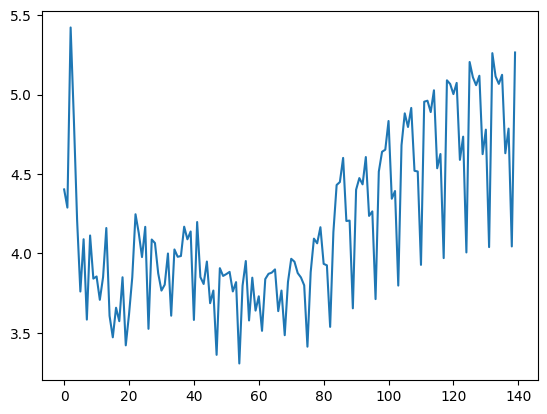

In [113]:
plt.plot(test_losses)

**To tell if the model is working I'm looking at test_bwd/fwd_pct_correct and seeing if that is doing better than chance (1/batch_size)**